## Customer Segmentation

### Task :

COO of Superstore, one of the leading e-commerce, wants to create a loyalty program in the form of benefits given to customers because they have become loyal customers. You as a Data Analyst in the Growth team are asked by the COO through the Data Manager to segment customers to design a loyalty program. However, neither the COO nor the Data Manager gave a clear strategy on what kind of segment to create. Everything related to market segmentation analysis and creation is left to you as long as the insights/recommendations made have a clear basis in the form of data and theoretical foundations (eg based on research in related fields, etc.).

1. Find category of goods has the largest number of sales and and the largest contributor to profit. Take the top 80% based on Pareto calculations
2. Find subcategory has the biggest sales and profits. Take the top 80% based on Pareto calculations
3. Find the region has the biggest profit contributor. Take the top 80% based on Pareto calculations
4. Find the city has the biggest profit contributor. Take the top 80% based on Pareto calculations
5. Find categories and subcategories are most frequently purchased for discounts. Take the top 80% based on Pareto calculations
6. Determine the customer segmentation using RFM

In [1]:
!pip install yellowbrick

In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy.spatial import ConvexHull

from datetime import datetime

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
color1 = 'steelblue'
color2 = 'red'
line_size = 4

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/superstore_dataset/global_superstore.csv')

In [4]:
df.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,...,product_id,category,sub_category,product_name,sales,quantity,discount,profit,shipping_cost,order_priority
0,32298,CA-2012-124891,2012-07-31T00:00:00Z,2012-07-31T00:00:00Z,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05T00:00:00Z,2013-02-07T00:00:00Z,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17T00:00:00Z,2013-10-18T00:00:00Z,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28T00:00:00Z,2013-01-30T00:00:00Z,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05T00:00:00Z,2013-11-06T00:00:00Z,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

In [5]:
df1 = df[['city','region','category','sub_category','sales','quantity','discount','profit']]
df1.head()

,city,region,category,sub_category,sales,quantity,discount,profit
0,New York City,East,Technology,Accessories,2309.650,7,0.0,762.1845
1,Wollongong,Oceania,Furniture,Chairs,3709.395,9,0.1,-288.7650
2,Brisbane,Oceania,Technology,Phones,5175.171,9,0.1,919.9710
3,Berlin,Central,Technology,Phones,2892.510,5,0.1,-96.5400
4,Dakar,Africa,Technology,Copiers,2832.960,8,0.0,311.5200


In [6]:
df1['category'].unique()

array(['Technology', 'Furniture', 'Office Supplies'], dtype=object)

### Pareto Analysis with Category

In [7]:
df1_category = df1.groupby(['category'], as_index=False).agg({
    'sales':'sum',
    'profit':'sum'
})
df1_category

,category,sales,profit
0,Furniture,4.110874e+06,285204.72380
1,Office Supplies,3.787070e+06,518473.83430
2,Technology,4.744557e+06,663778.73318


In [8]:
# Find cumulative percentage for sales category
df1_category_sales = df1_category.sort_values(by='sales', ascending=False).reset_index(drop=True)
df1_category_sales['cumperc_sales'] = df1_category_sales['sales'].cumsum()/df1_category_sales['sales'].sum()*100
df1_category_sales

,category,sales,profit,cumperc_sales
0,Technology,4.744557e+06,663778.73318,37.528628
1,Furniture,4.110874e+06,285204.72380,70.044931
2,Office Supplies,3.787070e+06,518473.83430,100.000000


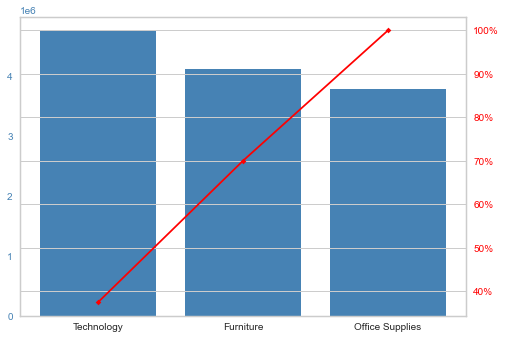

In [9]:
fig, ax = plt.subplots()
ax.bar(df1_category_sales['category'], df1_category_sales['sales'], color=color1)
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(df1_category_sales.index, df1_category_sales['cumperc_sales'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on visualization above, we know that all three categories are surpass 80% sales cutoff. With Technology and Furniture have filled 70% of cumulative percentage, and then the rest is filled by Office Suppliers.

In [10]:
# Find cumulative percentage for profit category
df1_category_profit = df1_category.sort_values(by='profit', ascending=False).reset_index(drop=True)
df1_category_profit['cumperc_profit'] = df1_category_profit['profit'].cumsum()/df1_category_profit['profit'].sum()*100
df1_category_profit

,category,sales,profit,cumperc_profit
0,Technology,4.744557e+06,663778.73318,45.233257
1,Office Supplies,3.787070e+06,518473.83430,80.564700
2,Furniture,4.110874e+06,285204.72380,100.000000


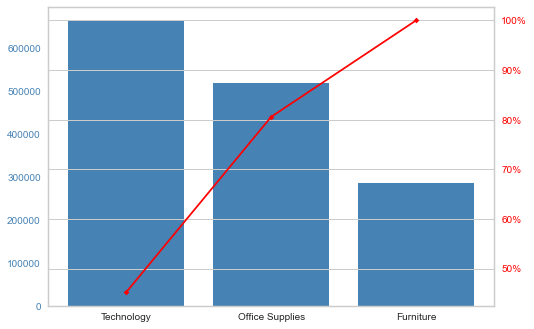

In [11]:
fig, ax = plt.subplots()
ax.bar(df1_category_profit['category'], df1_category_profit['profit'], color=color1)
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(df1_category_profit.index, df1_category_profit['cumperc_profit'], color=color2, marker="D", ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on visualization above there is a different about three categories for gain profit, Technology and Office Supplies are surpass 80% profit. Meanwhile, the Furniture didn't reach cutoff of the profit.

### Recommendation

Based on the insights that have been obtained is three categories are surpass 80% cutoff of the sales. However, only Technology and Office Supplies that surpass the cutoff of the profit. So, the company must doing a research for the Furniture category why this category are surpass cutoff of the sales, but didn't surpass cutoff the profit.

### Pareto Analysis with Sub_Category

In [12]:
df1_sub_category = df1.groupby(['sub_category'], as_index=False).agg({
    'sales':'sum',
    'profit':'sum'
})
df1_sub_category

,sub_category,sales,profit
0,Accessories,7.492370e+05,129626.30620
1,Appliances,1.011064e+06,141680.58940
2,Art,3.720920e+05,57953.91090
3,Binders,4.619115e+05,72449.84600
4,Bookcases,1.466572e+06,161924.41950
5,Chairs,1.501682e+06,140396.26750
6,Copiers,1.509436e+06,258567.54818
7,Envelopes,1.709043e+05,29601.11630
8,Fasteners,8.324232e+04,11525.42410
9,Furnishings,3.855783e+05,46967.42550


In [13]:
df1_sub_category_sales = df1_sub_category.sort_values(by='sales', ascending=False).reset_index(drop=True)
df1_sub_category_sales['cumperc_sales'] = df1_sub_category_sales['sales'].cumsum()/df1_sub_category_sales['sales'].sum()*100
df1_sub_category_sales

,sub_category,sales,profit,cumperc_sales
0,Phones,1.706824e+06,216717.00580,13.500683
1,Copiers,1.509436e+06,258567.54818,25.440063
2,Chairs,1.501682e+06,140396.26750,37.318105
3,Bookcases,1.466572e+06,161924.41950,48.918438
4,Storage,1.127086e+06,108461.48980,57.833492
5,Appliances,1.011064e+06,141680.58940,65.830835
6,Machines,7.790601e+05,58867.87300,71.993065
7,Tables,7.570419e+05,-64083.38870,77.981136
8,Accessories,7.492370e+05,129626.30620,83.907471
9,Binders,4.619115e+05,72449.84600,87.561111


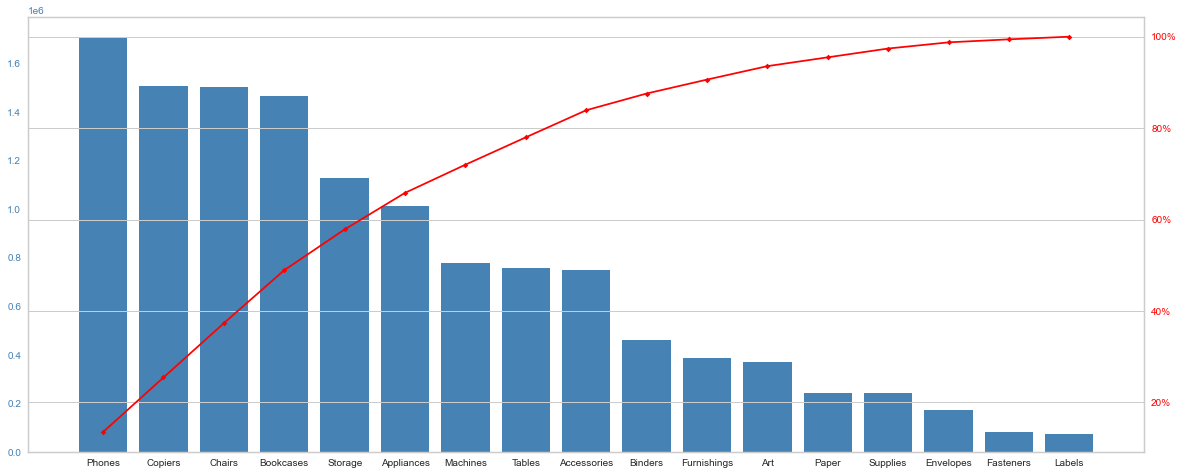

In [14]:
# Make Barplot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_sub_category_sales['sub_category'], df1_sub_category_sales['sales'], color=color1)
ax.grid(False)

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_sub_category_sales.index, df1_sub_category_sales['cumperc_sales'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on visualization above, there is 4 sub_categories that are surpass 80% cutoff the sales. The sub_categories are Phones, Copiers, Chairs, Bookcases. 

In [15]:
# Create cumulative percentage for profit
df1_sub_category_profit = df1_sub_category.sort_values(by='profit', ascending=False).reset_index(drop=True)
df1_sub_category_profit['cumperc_profit'] = df1_sub_category_profit['profit'].cumsum()/df1_sub_category_profit['profit'].sum()*100
df1_sub_category_profit

,sub_category,sales,profit,cumperc_profit
0,Copiers,1.509436e+06,258567.54818,17.620107
1,Phones,1.706824e+06,216717.00580,32.388306
2,Bookcases,1.466572e+06,161924.41950,43.422659
3,Appliances,1.011064e+06,141680.58940,53.077494
4,Chairs,1.501682e+06,140396.26750,62.644810
5,Accessories,7.492370e+05,129626.30620,71.478205
6,Storage,1.127086e+06,108461.48980,78.869323
7,Binders,4.619115e+05,72449.84600,83.806424
8,Paper,2.442917e+05,59207.68270,87.841136
9,Machines,7.790601e+05,58867.87300,91.852692


In [16]:
# Drop sub category Tables
df1_sub_category_profit = df1_sub_category_profit.drop(index=16)
df1_sub_category_profit

,sub_category,sales,profit,cumperc_profit
0,Copiers,1.509436e+06,258567.54818,17.620107
1,Phones,1.706824e+06,216717.00580,32.388306
2,Bookcases,1.466572e+06,161924.41950,43.422659
3,Appliances,1.011064e+06,141680.58940,53.077494
4,Chairs,1.501682e+06,140396.26750,62.644810
5,Accessories,7.492370e+05,129626.30620,71.478205
6,Storage,1.127086e+06,108461.48980,78.869323
7,Binders,4.619115e+05,72449.84600,83.806424
8,Paper,2.442917e+05,59207.68270,87.841136
9,Machines,7.790601e+05,58867.87300,91.852692


I decide to drop sub category Tables because there is a mins profit from this sub category which is didn't give good insight. And then, I will inform to business stakeholder to doing a research to find out the reason why profit from sub category Tables is mins value.

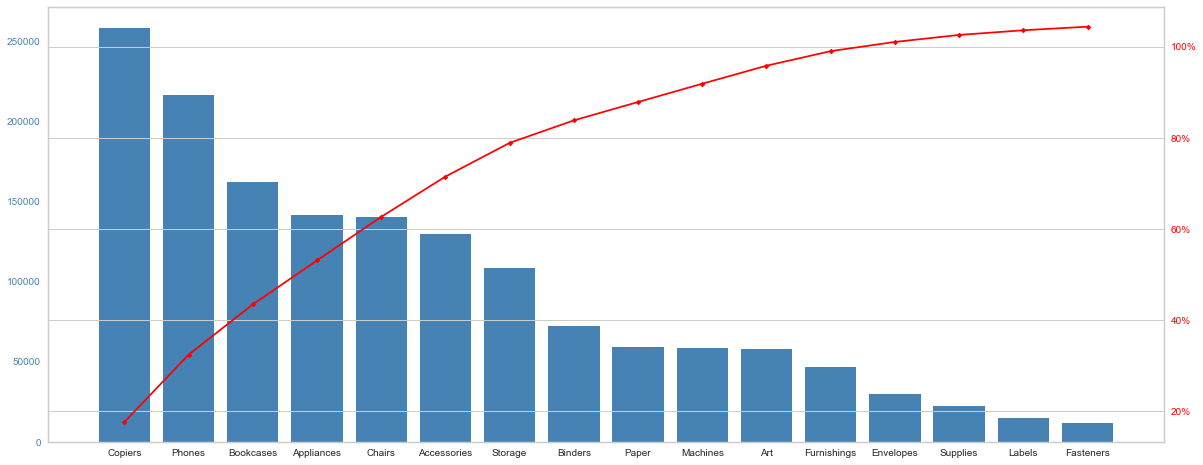

In [17]:
# Make bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_sub_category_profit['sub_category'], df1_sub_category_profit['profit'], color=color1)
ax.grid(False)

# Add cumulative percentage line to plot
ax2 = ax.twinx()
ax2.plot(df1_sub_category_profit.index, df1_sub_category_profit['cumperc_profit'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on visualization above there are two sub category that surpass 80% profit cutoff : Copies and Phones

### Recommendation

Based on pareto analysis in sales and profit of sub_category, there is four sub category (Copies, Phones, Bookcases, Chairs) that can surpass 80% of sales cutoff. However, only Copies and Phone that can surpass 80% of profit cutoff. Then, the Chairs and Bookcases only surpass 60% of profit cutoff so I think these sub category still quite good. However, company must still find a way to raise the profit of these two sub category to reach the profit cutoff.

In [18]:
df1_region = df1.groupby(['region'], as_index=False).agg({
    'profit':'sum'
})
df1_region

,region,profit
0,Africa,88871.63100
1,Canada,17817.39000
2,Caribbean,34571.32104
3,Central,311403.98164
4,Central Asia,132480.18700
5,EMEA,43897.97100
6,East,91522.78000
7,North,194597.95252
8,North Asia,165578.42100
9,Oceania,120089.11200


In [19]:
df1_region_profit = df1_region.sort_values(by='profit', ascending=False).reset_index(drop=True)
df1_region_profit['cumperc_profit'] = df1_region_profit['profit'].cumsum()/df1_region_profit['profit'].sum()*100
df1_region_profit

,region,profit,cumperc_profit
0,Central,311403.98164,21.220650
1,North,194597.95252,34.481544
2,North Asia,165578.42100,45.764900
3,South,140355.76618,55.329455
4,Central Asia,132480.18700,64.357328
5,Oceania,120089.11200,72.540811
6,West,108418.44890,79.928995
7,East,91522.78000,86.165823
8,Africa,88871.63100,92.221988
9,EMEA,43897.97100,95.213418


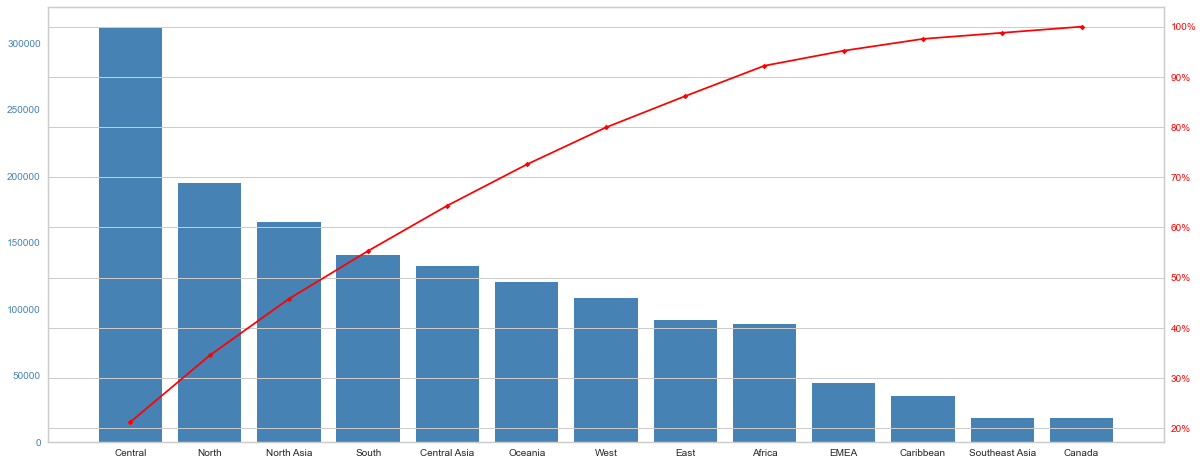

In [20]:
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_region_profit['region'], df1_region_profit['profit'], color=color1)
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(df1_region_profit.index, df1_region_profit['cumperc_profit'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

### Recommendation

Baseon on visualization above, there is only one region(Central) can surpass 80% of profit cutoff. I have an assumption for the company centered the business matters on Central region and just starting to expand business matters in other region. To increase the profit and gain more customer, company must expand the business in several region. If company will expand the business, I think there is four region can be considered : North, North Asia, South, and Central Asia. Because these region have surpass 50% profit cutoff.

In [21]:
df1.head()

,city,region,category,sub_category,sales,quantity,discount,profit
0,New York City,East,Technology,Accessories,2309.650,7,0.0,762.1845
1,Wollongong,Oceania,Furniture,Chairs,3709.395,9,0.1,-288.7650
2,Brisbane,Oceania,Technology,Phones,5175.171,9,0.1,919.9710
3,Berlin,Central,Technology,Phones,2892.510,5,0.1,-96.5400
4,Dakar,Africa,Technology,Copiers,2832.960,8,0.0,311.5200


In [22]:
df_city = df1.groupby(['city'], as_index=False).agg({
    'profit':'sum'
})
df_city

,city,profit
0,Aachen,1116.981
1,Aalen,283.005
2,Aalst,152.310
3,Aba,-1475.556
4,Abadan,233.820
...,...,...
3631,Zwedru,11.850
3632,Zwickau,19.380
3633,Zwolle,-55.095
3634,eMbalenhle,13.620


In [23]:
df_city_profit = df_city.sort_values(by='profit', ascending=False).reset_index(drop=True)
df_city_profit['cumperc_profit'] = df_city_profit['profit'].cumsum()/df_city_profit['profit'].sum()*100
df_city_profit

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
...,...,...,...
3631,Lahore,-13626.37200,105.092387
3632,Philadelphia,-13837.76740,104.149411
3633,Tegucigalpa,-15007.41608,103.126729
3634,Istanbul,-19960.90800,101.766492


In [24]:
df_city_profit[df_city_profit['profit'] == 0]

,city,profit,cumperc_profit
2945,Montería,0.0,145.62017
2946,Itapeva,0.0,145.62017
2947,Hengelo,0.0,145.62017
2948,Voiron,0.0,145.62017
2949,Senhor do Bonfim,0.0,145.62017


Based on table above, there is city that have cumulative percentage above 100 and city with no profit. I think these value must be droped from the table.

In [25]:
# Filtering non-profit and cumulative percentage
df_city_profit = df_city_profit.query('profit > 0')
df_city_profit = df_city_profit.query('cumperc_profit < 100')
df_city_profit

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
...,...,...,...
487,Cottbus,1117.64700,99.685918
488,Aachen,1116.98100,99.762035
489,Le Petit-Quevilly,1115.30100,99.838037
490,Fort-de-France,1114.21104,99.913965


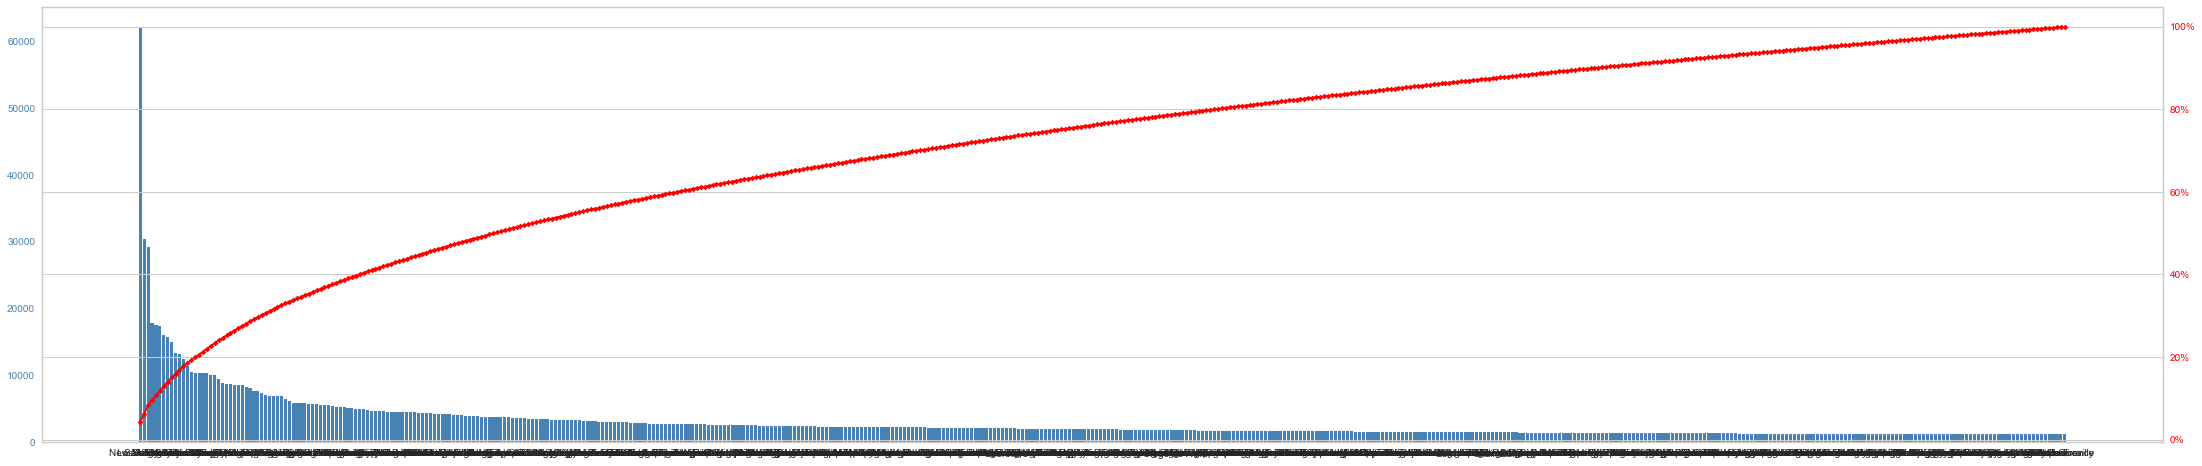

In [26]:
fig, ax = plt.subplots(figsize=(38,8))
ax.bar(df_city_profit['city'], df_city_profit['profit'], color=color1)
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(df_city_profit.index, df_city_profit['cumperc_profit'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

When too much unique city in data can make the visualization unreadable. I will show top 25 of city.

In [27]:
df_city_profit.head(25)

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
5,London,17378.71500,11.882707
6,Sydney,16002.80700,12.973220
7,Vienna,15660.84000,14.040429
8,San Salvador,15036.51040,15.065094
9,Mexico City,13342.29176,15.974305


In [28]:
df_city_profit_top25 = df_city_profit.query('profit > 8533.63199')
df_city_profit_top25

,city,profit,cumperc_profit
0,New York City,62036.98370,4.227515
1,Los Angeles,30440.75790,6.301903
2,Seattle,29156.09670,8.288748
3,Managua,17853.71804,9.505391
4,San Francisco,17507.38540,10.698433
5,London,17378.71500,11.882707
6,Sydney,16002.80700,12.973220
7,Vienna,15660.84000,14.040429
8,San Salvador,15036.51040,15.065094
9,Mexico City,13342.29176,15.974305


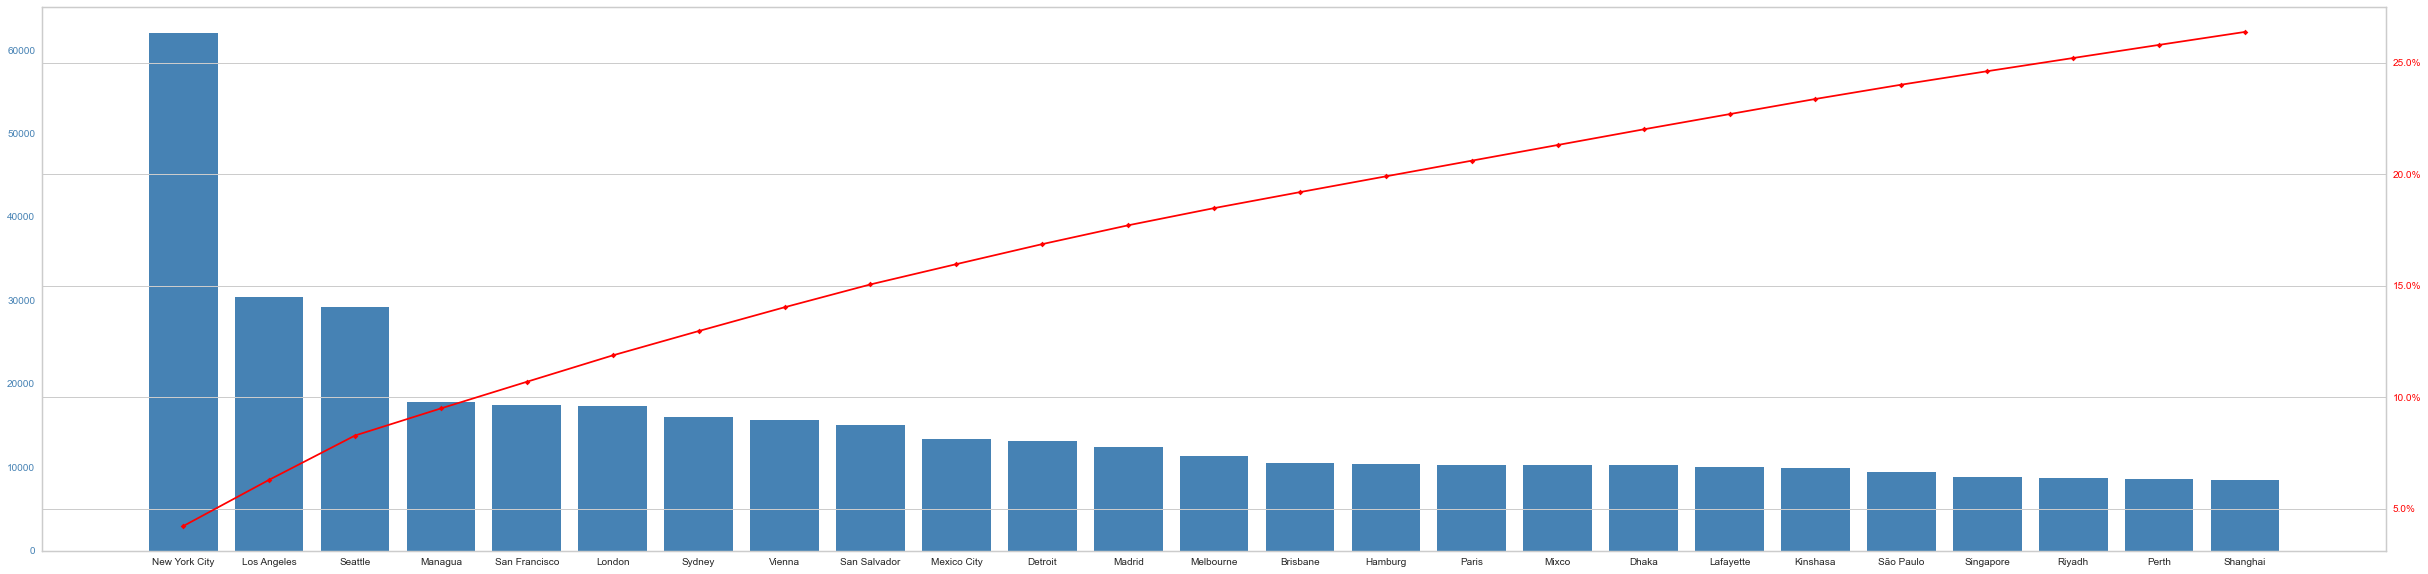

In [29]:
fig, ax = plt.subplots(figsize=(42,10))
ax.bar(df_city_profit_top25['city'], df_city_profit_top25['profit'], color=color1)
ax.grid(False)

ax2 = ax.twinx()
ax2.plot(df_city_profit_top25.index, df_city_profit_top25['cumperc_profit'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on 25 top city above, there is a 3 best city that can surpass 10% of profit (New York City, Los Angeles, Seattle).

### Recommendation

Based on visualization above, the only city that surpass profit cutoff 20% pareto analysis is New York City. These need further analysis, this could be because the company centered the business matter on New York City and just starting the expansion in other City. If not, the company must find a method to raise the profit from other City. The City can be considered to raise the profit is Los Angeles and Seattle because these city are surpass 10% of profit. In which, these city have a potential to raise the company profit.

### Find Sub Category and Category that purchase because discount

In [30]:
df1.head()

,city,region,category,sub_category,sales,quantity,discount,profit
0,New York City,East,Technology,Accessories,2309.650,7,0.0,762.1845
1,Wollongong,Oceania,Furniture,Chairs,3709.395,9,0.1,-288.7650
2,Brisbane,Oceania,Technology,Phones,5175.171,9,0.1,919.9710
3,Berlin,Central,Technology,Phones,2892.510,5,0.1,-96.5400
4,Dakar,Africa,Technology,Copiers,2832.960,8,0.0,311.5200


In [31]:
# Make a new dataframe with only necessary columns for category
df1_cdisc = df1.groupby(['category'], as_index = False).agg({
    'discount':'sum'
})
df1_cdisc

,category,discount
0,Furniture,1660.030
1,Office Supplies,4297.190
2,Technology,1372.508


In [32]:
# Find cumulative percentage of discount category
df1_cdisc = df1_cdisc.sort_values(by = 'discount', ascending = False).reset_index(drop = True)
df1_cdisc['cumperc_disc'] = df1_cdisc['discount'].cumsum()/df1_cdisc['discount'].sum()*100
df1_cdisc

,category,discount,cumperc_disc
0,Office Supplies,4297.190,58.626869
1,Furniture,1660.030,81.274776
2,Technology,1372.508,100.000000


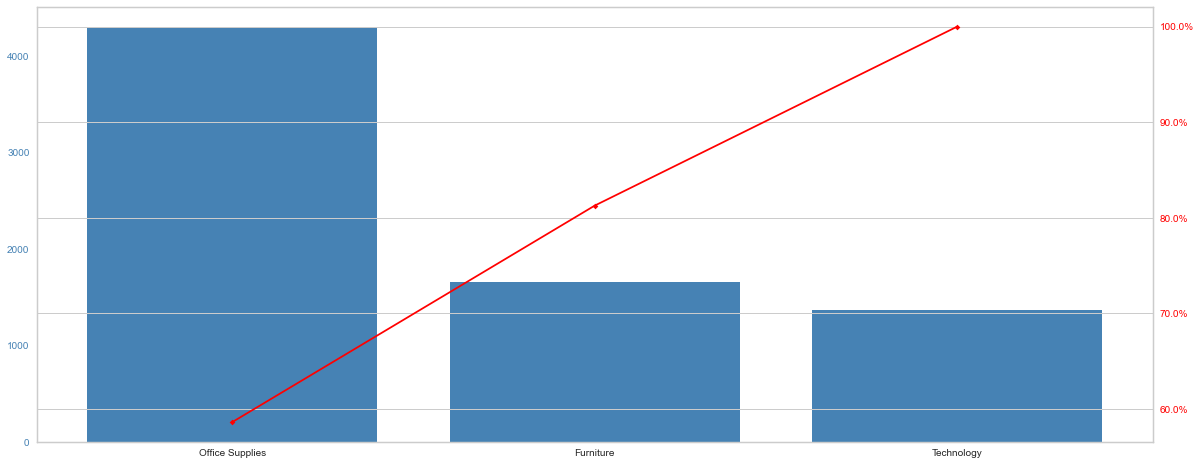

In [33]:
# Create bar plot
fig, ax = plt.subplots(figsize = (20,8))
ax.bar(df1_cdisc['category'], df1_cdisc['discount'], color=color1)
ax.grid(False)

# Add cumulative percentage line to
ax2 = ax.twinx()
ax2.plot(df1_cdisc.index, df1_cdisc['cumperc_disc'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on visualization above, the only category that surpass 80% discount cutoff is Office Supplies.

In [34]:
df1.head()

,city,region,category,sub_category,sales,quantity,discount,profit
0,New York City,East,Technology,Accessories,2309.650,7,0.0,762.1845
1,Wollongong,Oceania,Furniture,Chairs,3709.395,9,0.1,-288.7650
2,Brisbane,Oceania,Technology,Phones,5175.171,9,0.1,919.9710
3,Berlin,Central,Technology,Phones,2892.510,5,0.1,-96.5400
4,Dakar,Africa,Technology,Copiers,2832.960,8,0.0,311.5200


In [35]:
# Make a new dataframe with necessary column
df1_scdisc = df1.groupby(by='sub_category', as_index=False).agg({
    'discount':'sum'
})
df1_scdisc

,sub_category,discount
0,Accessories,370.480
1,Appliances,248.700
2,Art,573.080
3,Binders,1102.480
4,Bookcases,370.710
5,Chairs,560.120
6,Copiers,260.418
7,Envelopes,320.810
8,Fasteners,340.240
9,Furnishings,478.880


In [36]:
# Find cumulative percentage
df1_scdisc = df1_scdisc.sort_values(by='discount', ascending=False).reset_index(drop=True)
df1_scdisc['cumperc_disc'] = df1_scdisc['discount'].cumsum()/df1_scdisc['discount'].sum()*100
df1_scdisc

,sub_category,discount,cumperc_disc
0,Binders,1102.480,15.041213
1,Storage,700.490,24.598048
2,Art,573.080,32.416619
3,Chairs,560.120,40.058376
4,Phones,489.610,46.738160
5,Furnishings,478.880,53.271554
6,Paper,387.300,58.555515
7,Bookcases,370.710,63.613138
8,Accessories,370.480,68.667623
9,Fasteners,340.240,73.309542


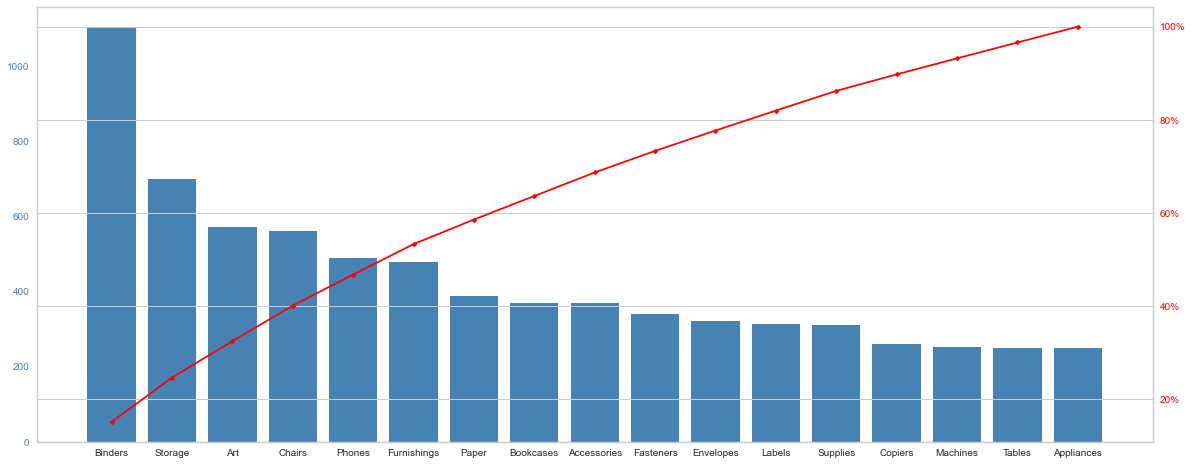

In [37]:
# Make bar plot
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(df1_scdisc['sub_category'], df1_scdisc['discount'], color=color1)
ax.grid(False)

# Add cumulative percentage plot
ax2 = ax.twinx()
ax2.plot(df1_scdisc.index, df1_scdisc['cumperc_disc'], color=color2, marker='D', ms=line_size)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Specify axis colors
ax.tick_params(axis='y', colors=color1)
ax2.tick_params(axis='y', colors=color2)

plt.show()

Based on visualization above, the highest discount on sub category that surpass 80% cutoff is Binders.

### Recommendation

From two visualization above there is a linear relation in which sub category Binders are from Office Supplies category. However, Binders as sub category didn't reach sales and profit cutoff. So the company need a further reseacrh, is the discount really good strategy for this sub category or not.

### RFM Analysis

In [38]:
# Checking data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   row_id          51290 non-null  int64  
 1   order_id        51290 non-null  object 
 2   order_date      51290 non-null  object 
 3   ship_date       51290 non-null  object 
 4   ship_mode       51290 non-null  object 
 5   customer_id     51290 non-null  object 
 6   customer_name   51290 non-null  object 
 7   segment         51290 non-null  object 
 8   city            51290 non-null  object 
 9   state           51290 non-null  object 
 10  country         51290 non-null  object 
 11  postal_code     9994 non-null   float64
 12  market          51290 non-null  object 
 13  region          51290 non-null  object 
 14  product_id      51290 non-null  object 
 15  category        51290 non-null  object 
 16  sub_category    51290 non-null  object 
 17  product_name    51290 non-null 

In [39]:
# Create new df for necessary column
df2 = df[['order_id', 'customer_id', 'order_date', 'sales', 'quantity']]
df2

,order_id,customer_id,order_date,sales,quantity
0,CA-2012-124891,RH-19495,2012-07-31T00:00:00Z,2309.650,7
1,IN-2013-77878,JR-16210,2013-02-05T00:00:00Z,3709.395,9
2,IN-2013-71249,CR-12730,2013-10-17T00:00:00Z,5175.171,9
3,ES-2013-1579342,KM-16375,2013-01-28T00:00:00Z,2892.510,5
4,SG-2013-4320,RH-9495,2013-11-05T00:00:00Z,2832.960,8
...,...,...,...,...,...
51285,IN-2014-62366,KE-16420,2014-06-19T00:00:00Z,65.100,5
51286,US-2014-102288,ZC-21910,2014-06-20T00:00:00Z,0.444,1
51287,US-2013-155768,LB-16795,2013-12-02T00:00:00Z,22.920,3
51288,MX-2012-140767,RB-19795,2012-02-18T00:00:00Z,13.440,2


In [40]:
# Create GMV colunm
df2['GMV'] = df2['sales'] * df2['quantity']
df2

,order_id,customer_id,order_date,sales,quantity,GMV
0,CA-2012-124891,RH-19495,2012-07-31T00:00:00Z,2309.650,7,16167.550
1,IN-2013-77878,JR-16210,2013-02-05T00:00:00Z,3709.395,9,33384.555
2,IN-2013-71249,CR-12730,2013-10-17T00:00:00Z,5175.171,9,46576.539
3,ES-2013-1579342,KM-16375,2013-01-28T00:00:00Z,2892.510,5,14462.550
4,SG-2013-4320,RH-9495,2013-11-05T00:00:00Z,2832.960,8,22663.680
...,...,...,...,...,...,...
51285,IN-2014-62366,KE-16420,2014-06-19T00:00:00Z,65.100,5,325.500
51286,US-2014-102288,ZC-21910,2014-06-20T00:00:00Z,0.444,1,0.444
51287,US-2013-155768,LB-16795,2013-12-02T00:00:00Z,22.920,3,68.760
51288,MX-2012-140767,RB-19795,2012-02-18T00:00:00Z,13.440,2,26.880


In [41]:
# Change order date to datetime
df2['order_date'] = pd.to_datetime(df2['order_date'])
df2

,order_id,customer_id,order_date,sales,quantity,GMV
0,CA-2012-124891,RH-19495,2012-07-31 00:00:00+00:00,2309.650,7,16167.550
1,IN-2013-77878,JR-16210,2013-02-05 00:00:00+00:00,3709.395,9,33384.555
2,IN-2013-71249,CR-12730,2013-10-17 00:00:00+00:00,5175.171,9,46576.539
3,ES-2013-1579342,KM-16375,2013-01-28 00:00:00+00:00,2892.510,5,14462.550
4,SG-2013-4320,RH-9495,2013-11-05 00:00:00+00:00,2832.960,8,22663.680
...,...,...,...,...,...,...
51285,IN-2014-62366,KE-16420,2014-06-19 00:00:00+00:00,65.100,5,325.500
51286,US-2014-102288,ZC-21910,2014-06-20 00:00:00+00:00,0.444,1,0.444
51287,US-2013-155768,LB-16795,2013-12-02 00:00:00+00:00,22.920,3,68.760
51288,MX-2012-140767,RB-19795,2012-02-18 00:00:00+00:00,13.440,2,26.880


In [42]:
# checking latest date of date
df2['order_date'].max()

Timestamp('2014-12-31 00:00:00+0000', tz='UTC')

In [43]:
# save date for analysis
analysis_date = df2['order_date'].max()

In [44]:
# grouping dataframe into proper columns
data_rfm = df2.groupby(['customer_id'], as_index=False).agg({
    'order_date': lambda x : (analysis_date - x.max()).days,
    'order_id':'count',
    'GMV':'sum'
})
data_rfm

,customer_id,order_date,order_id,GMV
0,AA-10315,8,42,56735.25400
1,AA-10375,6,42,23893.63700
2,AA-10480,125,38,89517.09654
3,AA-10645,28,73,72217.61334
4,AA-315,2,8,7865.97600
...,...,...,...,...
1585,YS-21880,9,54,96423.61400
1586,ZC-11910,200,1,7.17300
1587,ZC-21910,3,84,155687.54878
1588,ZD-11925,3,18,11160.13200


In [45]:
data_rfm.rename(columns={'customer_id':'customer',
                        'order_date':'Recency',
                        'order_id':'Frequency',
                        'GMV':'Monetary'}, inplace=True)

In GMV data may contain a negative values (this is because sometimes the price may be negative as impact of loss sales), we decide to delete it from segmentation because loss sales didn't give good insight for the segmentation.

In [46]:
data_rfm = data_rfm[data_rfm['Monetary'] > 0]

In [47]:
data_rfm

,customer,Recency,Frequency,Monetary
0,AA-10315,8,42,56735.25400
1,AA-10375,6,42,23893.63700
2,AA-10480,125,38,89517.09654
3,AA-10645,28,73,72217.61334
4,AA-315,2,8,7865.97600
...,...,...,...,...
1585,YS-21880,9,54,96423.61400
1586,ZC-11910,200,1,7.17300
1587,ZC-21910,3,84,155687.54878
1588,ZD-11925,3,18,11160.13200


In [48]:
# define labels for RFM and separate the data into 4 quantile
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_groups = pd.qcut(data_rfm['Recency'], q=4, labels = r_labels)
f_groups = pd.qcut(data_rfm['Frequency'], q=4, labels = f_labels)
m_groups = pd.qcut(data_rfm['Monetary'], q=4, labels = m_labels)

In [49]:
# assign the labels to R,F,M columns
data_rfm = data_rfm.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)

In [50]:
# define score based on labels
data_rfm['rfm_score'] = data_rfm[['R','F','M']].apply(
    lambda x : ''.join(x.astype(str)),
    axis=1
)

In [51]:
# change rfm score data type into integer for further analysis
data_rfm['rfm_score'] = data_rfm['rfm_score'].astype('int')

In [53]:
# check final data
data_rfm.head(10)

,customer,Recency,Frequency,Monetary,R,F,M,rfm_score
0,AA-10315,8,42,56735.25400,4,3,3,433
1,AA-10375,6,42,23893.63700,4,3,2,432
2,AA-10480,125,38,89517.09654,1,3,4,134
3,AA-10645,28,73,72217.61334,3,4,4,344
4,AA-315,2,8,7865.97600,4,1,2,412
5,AA-375,253,13,1566.30000,1,2,1,121
6,AA-480,314,10,5794.62300,1,1,2,112
7,AA-645,51,18,4264.86000,2,2,1,221
8,AB-10015,16,77,94513.69970,3,4,4,344
9,AB-10060,42,57,102219.22340,2,4,4,244


### Post Segmentation Analysis

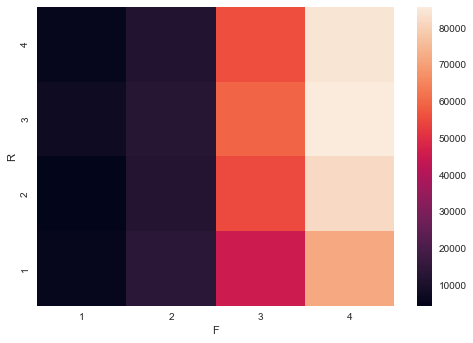

In [54]:
# heatmap visualization
sns.heatmap(pd.pivot_table(data_rfm[['R','F','Monetary']], values = 'Monetary', index = ['R'], columns = ['F']));

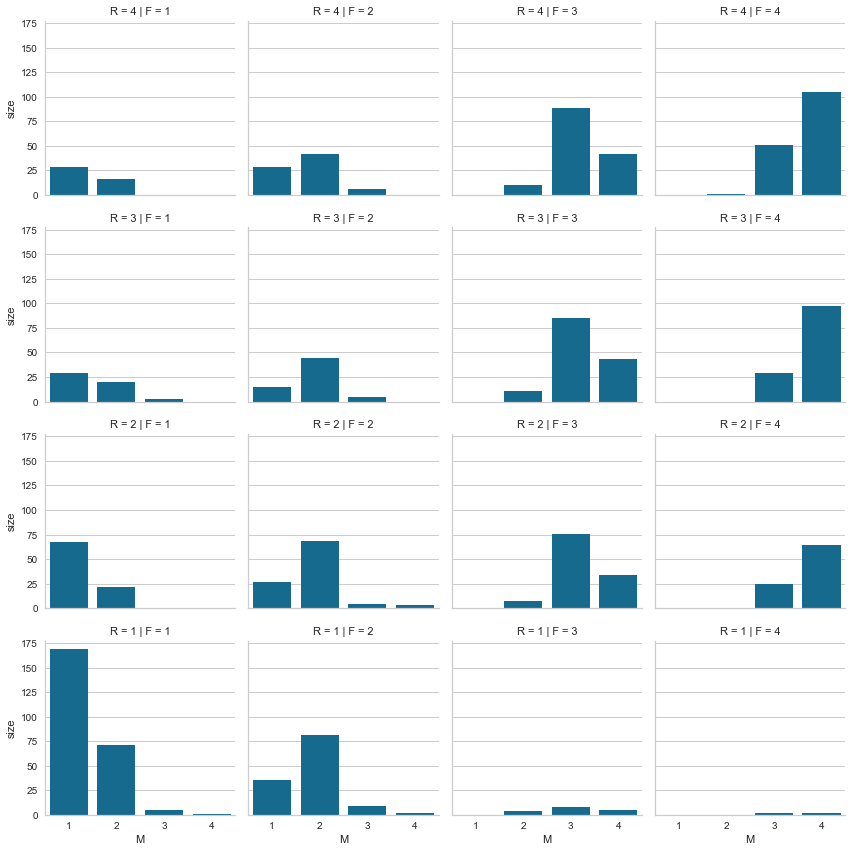

In [55]:
# RFM distribution
rfm_bar_data = data_rfm[['R','F','M']].groupby(['R','F','M'], as_index=False).size()

d = sns.FacetGrid(
    data = rfm_bar_data,
    col = 'F',
    row = 'R'
)
d.map(sns.barplot, 'M', 'size');

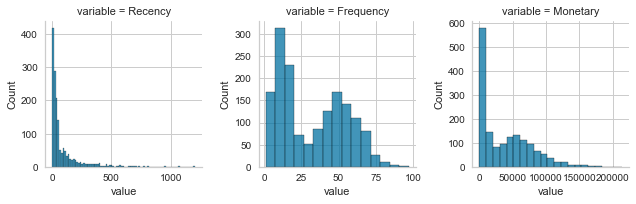

In [56]:
# Recency, Frequency, Monetary distribution
d = sns.FacetGrid(
    data = pd.melt(
    data_rfm[['Recency', 'Frequency', 'Monetary']],
    value_vars = ['Recency', 'Frequency', 'Monetary']
    ),
    col = 'variable',
    sharex = False,
    sharey = False
)
d.map(sns.histplot, 'value');

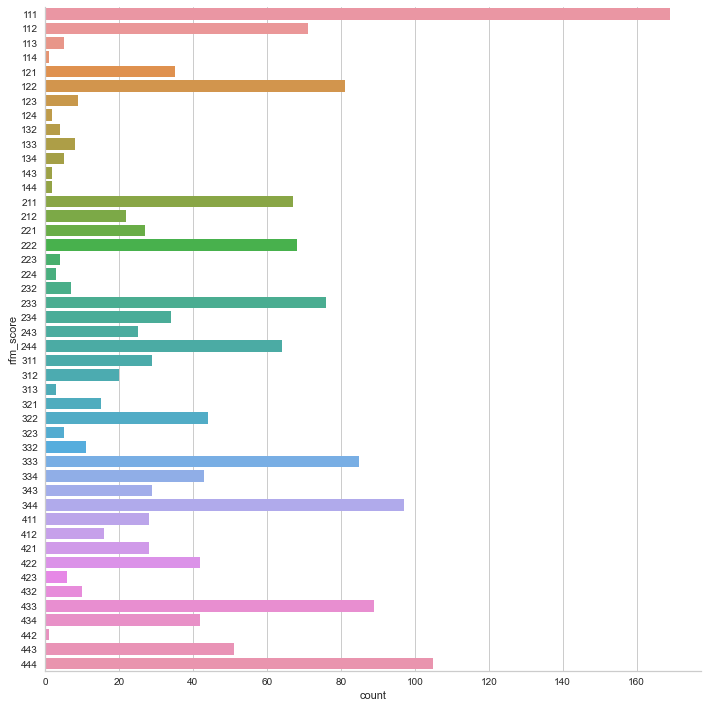

In [57]:
# RFM score to RFM segment
sns.catplot(
    y = 'rfm_score',
    data = data_rfm.sort_values(by = ['rfm_score'], axis = 0),
    kind = 'count',
    height = 10
);

For the segmentation we tried to divide the customer to five segmentations :

1. Champion : customer with highest rfm score 444 point.
2. Promising : customer two 4 point rfm score, in which have 3 or 4 score on Recency, these customer have highest possibility to turn into champion customer which is valuable asset for company.
3. Average : customer considered as normal customer with average score, which is have at least double 3 score or combined 3 & 4 score each 1.
4. At Risk : customer with double 1, 2, or both point rfm score, for this customer the company must handle this seriously so didn't turn to lost customers.
5. Lost : these customer with the lowest rfm score, so the company must take out these customers from any marketing and promotion consideration.

In [58]:
data_rfm['rfm_segment'] = np.select(
    [
     data_rfm['rfm_score'].isin([444]),
     data_rfm['rfm_score'].isin([344, 434, 443, 414, 424, 441, 442]),
     data_rfm['rfm_score'].isin([313, 314, 333, 334, 343, 433, 323, 324, 331, 332, 341, 342, 413, 423, 431, 432, 133, 134, 143, 144, 233, 234, 243, 244]),
     data_rfm['rfm_score'].isin([112, 113, 114, 121, 131, 141, 211, 311, 411, 221, 222, 223, 224, 232, 231, 241, 242, 312, 321, 322, 412, 422, 421, 122, 123, 124, 132, 142, 212, 213, 214]),
     data_rfm['rfm_score'].isin([111])
    ],
    [
     'Champion Customers',
     'Promising Customers',
     'Average Customers',
     'At Risk Customers',
     'Lost Customers'
    ]
)

data_rfm.head(10)

,customer,Recency,Frequency,Monetary,R,F,M,rfm_score,rfm_segment
0,AA-10315,8,42,56735.25400,4,3,3,433,Average Customers
1,AA-10375,6,42,23893.63700,4,3,2,432,Average Customers
2,AA-10480,125,38,89517.09654,1,3,4,134,Average Customers
3,AA-10645,28,73,72217.61334,3,4,4,344,Promising Customers
4,AA-315,2,8,7865.97600,4,1,2,412,At Risk Customers
5,AA-375,253,13,1566.30000,1,2,1,121,At Risk Customers
6,AA-480,314,10,5794.62300,1,1,2,112,At Risk Customers
7,AA-645,51,18,4264.86000,2,2,1,221,At Risk Customers
8,AB-10015,16,77,94513.69970,3,4,4,344,Promising Customers
9,AB-10060,42,57,102219.22340,2,4,4,244,Average Customers


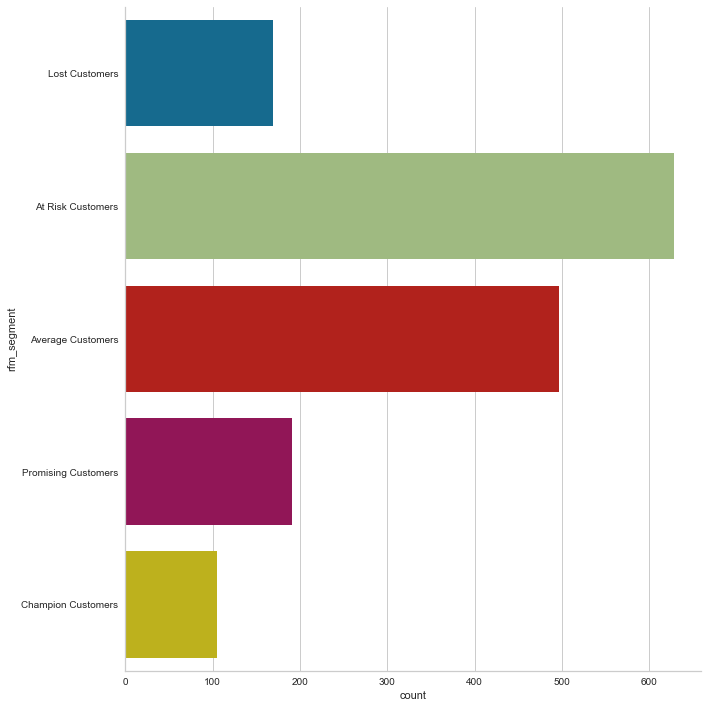

In [59]:
sns.catplot(
    y = 'rfm_segment',
    data = data_rfm.sort_values(by = ['rfm_score'], axis = 0),
    kind = 'count',
    height = 10
);

### Recommendation

From the analysis above, we found that the lowest segmentation(111 RFM score) have the highest count value. It's not good for the company since the customer with low value are the higherst percentage amongs all, so the company must find the cause as soon as possible. However, the highest segmentation(444 RFM score) have ranked two based on count values. So, the company can rise up these champion customer to overcome the customer with lowest segmentation.

If we take a look at segmentation, "At Risk Customers" have highest count. In which, the company must save this customer and turn them into average customer at least before lost them.